## Eightball Titanic Survival Example

The Titanic data set consists of a set of demographic and socioeconomic features from the passengers on the RMS Titanic. The data set provided here is broken up into test and training sets, where the training set includes the target variable indicating whether the passenger survived the shipwreck ("Survived"). This data set was taken from kaggle (https://www.kaggle.com/c/titanic).

In [1]:
from eightball import model
from eightball import preprocessor 

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

eightball works best with pandas dataframes. The target variable is just an additional column in the training set. The index is optional, but is helpful as a reference when making predictions.

In [2]:
df_train = pd.read_csv('train.csv', index_col='PassengerId')
df_test = pd.read_csv('test.csv', index_col='PassengerId')
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Most classification algorithms can't deal with missing values or categorical variables out of the box. These issues are typically handled as separate steps from fitting and predicting. Eightball's primary utility is packaging all of the steps to go from raw data to predictions into a single object (which can then be saved as a single file). As a soft introduction to the mechanics of the eightball workflow, let's first only consider numeric features that don't have missing values.

In [3]:
df_train_only_numeric_not_null = df_train[['Pclass', 'SibSp', 'Parch', 'Survived']].copy()

An eightball model object consists of a classifier and a training data set. We also need to indicate which column is the target variable. Eightball was designed to work with any scikit-learn binary classifier, but should work with other classification libraries that use an interface similar to scikit learn's (namely that they use the `fit`, `predict_proba`/`predict` paradigm).

In [4]:
clf = RandomForestClassifier()
eightball_model = model.Model(clf, df_train_only_numeric_not_null, target_column='Survived')
eightball_model.fit()

Predictions are made by passing a feature set to the model's `predict` method

In [5]:
df_pred = eightball_model.predict(df_test)
df_pred.head()

,prob
PassengerId,
892,0.204036
893,0.279213
894,0.346804
895,0.204036
896,0.461928


Note that by default predict returns the probability of for the positive class. If desired, a binary prediction can be obtained setting the `proba` argument to `False`.

In [6]:
df_pred = eightball_model.predict(df_test, proba=False)
df_pred.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


### Evaluation
The model's `evaluate` method will perform a cross validated evaluation on the training set. By default the 5-fold cross validation if performed to generate `brier` and `roc_auc` scores.

In [7]:
eightball_model.evaluate()
eightball_model.eval_results.print_scores()

brier: 0.2078613791004879 +/- 0.027986961460994133
roc_auc: 0.722124689327804 +/- 0.06336911558157128


Different scoring metrics can be used by passing the evaluate method a dictionary of score methods or a string (currently 'brier', 'roc_auc', and 'accuracy' are supported strings).

In [32]:
eightball_model.evaluate(scoring='accuracy', cv=3)
eightball_model.eval_results.print_scores()

accuracy: 0.7923681257014591 +/- 0.017887067845689365


If the classification algorithm includes the calculation of feature importance, that will be included as part of the evaluation results as a sorted dataframe. the eval_results object also includes a method to plot a bar graph of feature importance.

In [9]:
eightball_model.eval_results.feature_importance_

,feature,score
0,Pclass,2.784933
1,Parch,1.653037
2,SibSp,1.562030


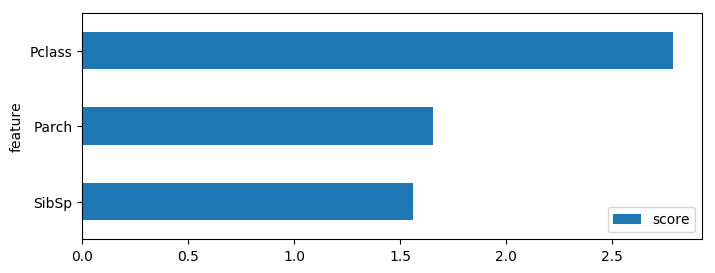

In [10]:
eightball_model.eval_results.plot_feature_importance()

### Missing Values / Imputation
The eightball model includes several basic imputation methods to deal with missing data. You can also include your own custom imputation technique (more in a later example). Let's look at the Titanic example again but include `Age` and `Fare` (both of which had missing values in either the training or test set).

accuracy: 0.6722427970623313 +/- 0.03679392728227628


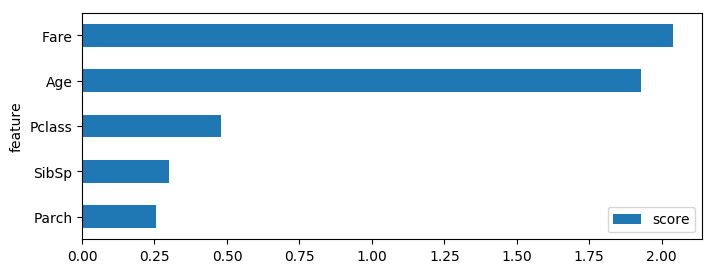

In [11]:
df_train_only_numeric = df_train[['Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'Survived']].copy()
clf = RandomForestClassifier()
eightball_model = model.Model(clf, df_train_only_numeric, target_column='Survived', imputer_='mean')

eightball_model.fit()
eightball_model.evaluate(scoring='accuracy', proba=False)
eightball_model.eval_results.print_scores()
eightball_model.eval_results.plot_feature_importance()

To use one of eightball's simple imputation techniques, `imputer_` can be set to 'zero', 'mean', 'median', or 'most_frequent'. Imputation parameters will be calculated from the training set and used when imputing values for the training set and when making predictions.

### Preprocessing data
Data sets often require some degree of preprocessing before either models can be trained or predictions can be made. For example, most classifcation algorithms require numerical data, so categorical features must first be converted to numerical features before training or making predictions. As with imputation, it's crucial that any data fed to a classifier for predictions undergo the same preprocessing as the training data set. Thus, as with imputation, eightball packages the preprocessing procedures together with the model. With eightball this is done by defining a Preprocessor object. This Preprocessor object must include a `fit` method and a `transform` method. It's recommended (though not required) that your custom Preprocessor class inherit eightball's `preprocessor.Preprocessor` class. This will give you a few freebie methods. Below we define a `TitanicPreprocessor` class that we'll use on the Titanic data set. This `TitanicPreprocessor` class includes a method to convert the `Name` feature into a `title` feature ("Mr", "Miss", etc.). The `process` method will be run on the training set before fitting and on any prediction data before making predictions. Notice that in addition to the custom `add_title` method, we're also using a `make_others` method which regroups any instances of a feature with low counts as "Other", and an `encode_categories` method, which turns categorical features into binary features using one hot encoding. Note that we didn't need to include a `fit` method since it's included in inheritted `preprocessor.Preprocessor` class.

In [12]:
class TitanicPreprocessor(preprocessor.Preprocessor):
    def __init__(self, others_min_count=3):
        self.others_min_count = others_min_count

    def add_title(self, df):
        df = df.copy()
        titles = []
        for n in df['Name']:
            try:
                titles.append(n.split(', ')[1].split('.')[0])
            except Exception:
                titles.append('Unknown')
        df['title'] = titles
        df.drop('Name', axis=1, inplace=True)
        return df
    
    def transform(self, df):
        df = self.add_title(df)
        df = self.make_others(df, 'title', self.others_min_count)
        df = self.encode_categories(df, cat_cols = ['Pclass', 'Sex', 'Embarked', 'title'])
        df = df.drop(['Ticket', 'Cabin', 'Age'], axis=1)
        return df

Now our eightball object includes the classifier, the training data set, an imputation method, and a preprocessor object.

In [30]:
clf = RandomForestClassifier()
tit_preproc = TitanicPreprocessor(others_min_count=15)
eightball_model = model.Model(
    clf, df_train,
    target_column='Survived',
    imputer_='zero',
    preprocessor_=tit_preproc,
    warn_level='quiet'
)

accuracy: 0.7822735547046638 +/- 0.01336645099344602


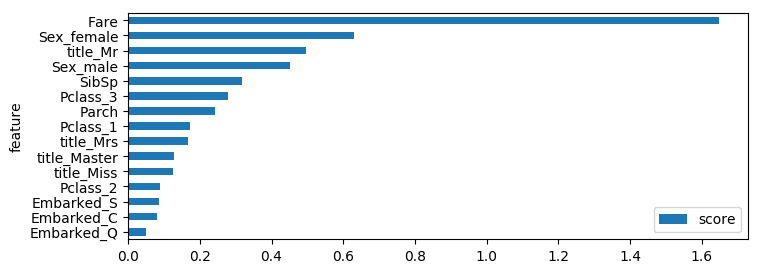

In [31]:
eightball_model.fit()
eightball_model.evaluate(scoring='accuracy', proba=False)
eightball_model.eval_results.print_scores()
eightball_model.eval_results.plot_feature_importance()

Predictions are obtained in the same way as above. Preprocessing and imputation are performed on any data before predictions are made.

In [15]:
df_pred = eightball_model.predict(df_test)
df_pred.head()

,prob
PassengerId,
892,0.025714
893,0.100000
894,0.057198
895,0.154105
896,0.200000


All steps required to make predictions on the test data set are packaged into the `eightball_model` object. This object includes a `save` object for saving to disk for use later or on a different machine. eightball's model module includes a `load` method for loading this model again for future use.

In [16]:
eightball_model.save('eightball_model.pkl')
del eightball_model

In [17]:
eightball_model_reloaded = model.load('eightball_model.pkl')
eightball_model_reloaded.predict(df_test).head()

,prob
PassengerId,
892,0.025714
893,0.100000
894,0.057198
895,0.154105
896,0.200000
